# Training Neural Networks

Neural Network를 정의하고 훈련하여 MNIST 데이터 셋으로부터 손글씨 숫자를 인식하도록 훈련(train)하자.

<img src="./assets/function_approx.png" width=500px>


훈련 데이터로 신경망의 parameter (=weights,bias)를 우리가 원하는 답에 가깝게 근사하도록 해야 한다.

이러한 parameters를 찾기 위해서,loss function (=cost function)를 사용한다. 회귀문제에서 loss 함수는 mean squared loss를 사용하고 분류 문제를 위해서는 cross entropy를 주로 활용한다.

예를 들면 regression문제에서 사용되는 mean squared loss는 다음과 같다.

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

$n$ training examples의 갯수이다. $y_i$ 는 데이터의 true labels이고 $\hat{y}_i$ 는 predicted labels이다.


신경망의 학습 목표는 이러한 loss를 최소화하는 parameter를 찾는 것에 있다. 이러한 과정은 **gradient descent** 알고리즘을 활용한다. gradient 는 어떤 한점에서 loss function의 기울기를 말하고 이것은 해당 loss를 가장 빠르게 감소할수 있는 방향과 크기를 나타낸다. loss를 최소화하는 방향으로 진행하는 학습은 높은 산을 내려가는 방법과 비교할 수 있다.


<img src='./assets/gradient_descent.png' width=350px>

## Backpropagation

깊이가 깊은 multilayer neural network에서는 gradient를 계산하기 쉽지 않다. multilayer networks를 훈련하기 위한 다양한 연구가 진행되어 왔다.

backpropagation을 이해하기 쉽도록 2 layer network의 computational graph로 표현하면 다음과 같다.

<img src='./assets/backprop_diagram.png' width=550px>

forward pass는 network에서 데이터가 bottom 에서 top으로 이동하는 방향이다. 그리고 최종적으로 loss $\ell$을 계산한다. 훈련의 목적은 loss를 최소화하는 weights 와 biases 를 찾는 것이다.

gradient descent로 weight를 훈련시키기 위해, loss를 backwards로 전파한다. multilayer networks를 훈련하기 위한 방법이 **backpropagation**  이다. 궁극적으로 backpropagation은 합성함수 미분에서 chain rule를 구현하는 것이다. 

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**Note:** 

weights를 업데이트하기 위해 learning rate $\alpha$ 를 사용한다. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

learning rate $\alpha$ 은 weight를 update하는 steps을 조절하여 loss를 최소화하는 값에 수렴하도록 한다. 

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('TensorFlow version:', tf.__version__)
print('tf.keras version:', tf.keras.__version__)
print(' Running on GPU' if tf.test.is_gpu_available() else 'GPU device not found. Running on CPU')

Using:
TensorFlow version: 2.3.0
tf.keras version: 2.4.0
GPU device not found. Running on CPU


## Load the Dataset

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Create Pipeline

In [6]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

num_training_examples = x_train.shape[0]

X_train = x_train.reshape(num_training_examples, 28, 28,1)
training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)

## Build the Model

In [7]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

## Getting the Model Ready For Training

model을 훈련하기 위해 `.compile` method의 parameter를 설정해야 한다.


* **Optimizer:** training에서 weight를 update할 때 사용할 algorithm을 설정한다. 이 예제에서는 [`adam`](http://arxiv.org/abs/1412.6980) optimizer를 사용한다.  `tf.keras` 에서 제공하는 전체 optimizer 목록은 다음 링크를 확인한다.[optimizers documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers#classes).


* **Loss Function:**  loss function은 prediction과 실제 data의 label과의 차이를 계산한다. 이 예제에서는 `sparse_categorical_crossentropy` loss function를 사용한다. `sparse_categorical_crossentropy` loss function는 labels 이 정수인 경우에 사용한다. 그리고 `categorical_crossentropy` loss function은 one-hot encoded labels에서 사용한다. `tf.keras`에서 제공하는 loss functions 의 전체 목록은 다음 링크에서 확인한다. [losses documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses#classes).


* **Metrics:** metrics 는 모형을 훈련하는 과정에서 모형을 평가하는데 사용된다.  to be evaluated by the model during training. Throughout these lessons we will measure the `accuracy` of our model. The `accuracy` calculates how often our model's predictions match the true labels of the images in our dataset. For a full list of the metrics available in `tf.keras` check out the [metrics documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics#classes).

These are the main parameters we are going to set throught these lesson. You can check out all the other configuration parameters in the [TensorFlow documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#compile)

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Taking a Look at the Loss and Accuracy Before Training

model은 훈련되기 전에 random weight를 사용한다. 일단 batch를 1개 가져와서 `loss` 와 `accuracy` 를 확인해 본다. `.evaluate(data, true_labels)` method를 사용하여 loss와 accuracy를 계산할 수 있다.


In [9]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))

2/2 [==============================] - 0s 0s/step - loss: 2.2638 - accuracy: 0.2500

Loss before training: 2.264
Accuracy before training: 25.000%


## Training the Model

training set을 사용하여 model을 훈련한다. batch size 로 나누어 전체 데이터를 훈련하는 단위를 *epoch*이라고 한다. `.fit` method를 사용하여 정해진 epoch만큼 훈련을 수행한다.

In [10]:
EPOCHS = 5

history = model.fit(training_batches, epochs = EPOCHS)

Epoch 1/5
938/938 [==============================] - 1s 2ms/step - loss: 0.2761 - accuracy: 0.9204
Epoch 2/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1153 - accuracy: 0.9655
Epoch 3/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0804 - accuracy: 0.9754
Epoch 4/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0592 - accuracy: 0.9814
Epoch 5/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0472 - accuracy: 0.9849


`.fit` method 는 `History` object를 리턴한다. `History` object에는 훈련중에 accuracy 와 loss values를 기록한다.

훈련된 모형을 사용하여 predictions을 실행할 수 있다.

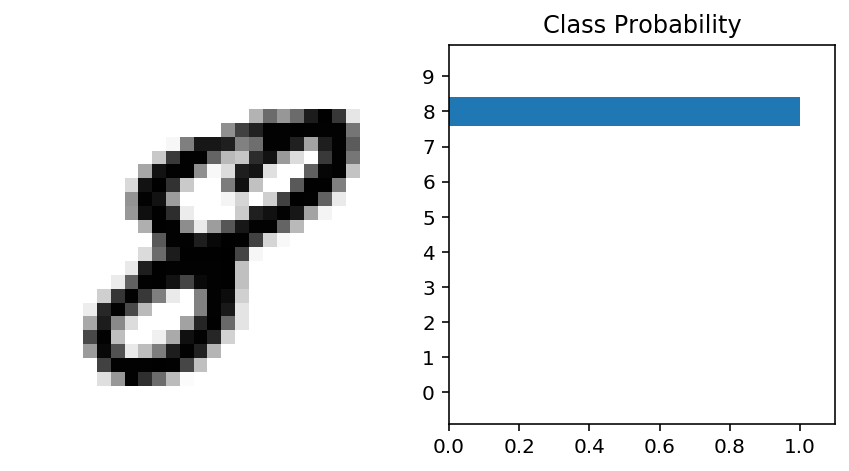

In [11]:
for image_batch, label_batch in training_batches.take(1):
    ps = model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
  
  
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

훈련된 모형을 사용하여 다시 evaluate 해본다.

In [12]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

2/2 [==============================] - 0s 1ms/step - loss: 0.0457 - accuracy: 0.9844

Loss after training: 0.046
Accuracy after training: 98.438%


> **실습하기:** 다음과 같은 network 모형을 생성하시오. 
* input units : 784 
* 1번째 hidden layer units : 128 
* 2번째 hidden layer unit 64 
* 세번째 hidden layer units : 32 
* 마지막 output layer units : 10 . U

> 모든 hidden layer에 ReLu activation function를 사용한다. 마지막 output layer에서는 softmax activation function를 사용한다. 

> model compile에서 optimizer는 `adam` optimizer, loss 함수로는 `sparse_categorical_crossentropy` loss function를 사용하고 metric은 `accuracy`로 설정한다. 마지막으로 1개의 batch를 가져와서 훈련되지 않은 모형의 loss 와 accuracy를 화면에 출력하시오.

In [13]:
## Solution
my_model = tf.keras.Sequential([
           tf.keras.layers.Flatten(input_shape = (28,28,1)),
           tf.keras.layers.Dense(128, activation = 'relu'),
           tf.keras.layers.Dense(64, activation = 'relu'),
           tf.keras.layers.Dense(32, activation = 'relu'),
           tf.keras.layers.Dense(10, activation = 'softmax')
])


my_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])


for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = my_model.evaluate(image_batch, label_batch)
    
    
print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))

2/2 [==============================] - 0s 8ms/step - loss: 2.3555 - accuracy: 0.1406

Loss before training: 2.356
Accuracy before training: 14.062%


> **실습하기:** 5 epochs 으로 모형을 훈련한다. 훈련된 모형에 1개 batch를 사용하여 loss 와 accuracy를 출력해 본다.

In [14]:
EPOCHS = 5

history = my_model.fit(training_batches, epochs = EPOCHS)

for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = my_model.evaluate(image_batch, label_batch)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

Epoch 1/5
938/938 [==============================] - 1s 1ms/step - loss: 0.2906 - accuracy: 0.9151
Epoch 2/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1152 - accuracy: 0.9657
Epoch 3/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0806 - accuracy: 0.9751
Epoch 4/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0616 - accuracy: 0.9809
Epoch 5/5
2/2 [==============================] - 0s 8ms/step - loss: 0.0088 - accuracy: 1.0000

Loss after training: 0.009
Accuracy after training: 100.000%


> **실습하기:** 임의의 훈련이미지으로 prediction을 수행하고 각 class 에 예측 확률을 시각화하여 보시오.

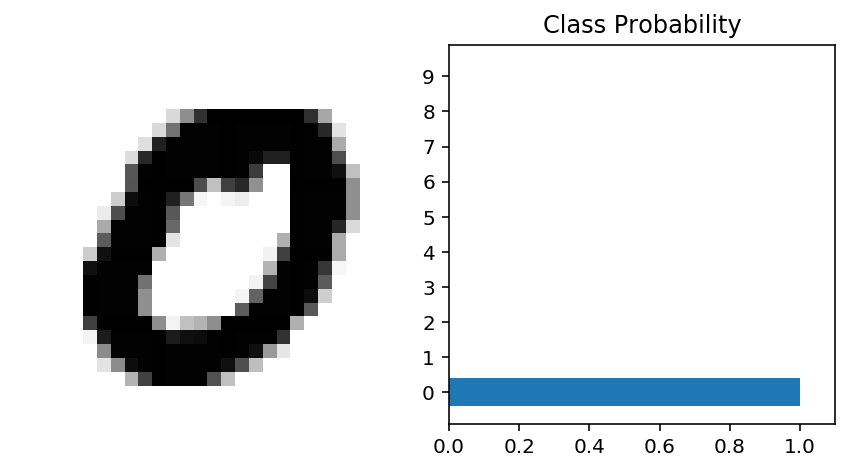

In [15]:
## Solution
for image_batch, label_batch in training_batches.take(1):
    ps = my_model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
  
  
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

## Automatic Differentiation


TensorFlow에서는 backpropagation을 위해서 gradients를 tracking한다. 

TensorFlow는 자동 미분(automatic differentiation) 기능을 위해서 `tf.GradientTape` 를 제공한다.

`tf.GradientTape` 는 tensor에 행해지는 operation을 기록한다. 기본적으로 `tf.GradientTape` network의 weight를 기록하게 되어 있다. `trainable=True`로 설정할 수 있다. `tf.keras`로 모형을 생성하면 모든 parameters는 기본적으로 `trainable = True`로 설정된다.


예를 들어 다음과 같은 간단한 방정식을 생각해 보자:

$$
y = x^2
$$

`y`를 `x`에 대해 미분하면 다음과 같다:

$$
\frac{d y}{d x} = 2x
$$

`tf.GradientTape`를 사용하여 미분을 실행해 보자.

In [16]:
# Set the random seed so things are reproducible
tf.random.set_seed(7)

# Create a random tensor
x = tf.random.normal((2,2))

# Calculate gradient
with tf.GradientTape() as g:
    g.watch(x)
    y = x ** 2
    
dy_dx = g.gradient(y, x)

# Calculate the actual gradient of y = x^2
true_grad = 2 * x

# Print the gradient calculated by tf.GradientTape
print('Gradient calculated by tf.GradientTape:\n', dy_dx)

# Print the actual gradient of y = x^2
print('\nTrue Gradient:\n', true_grad)

# Print the maximum difference between true and calculated gradient
print('\nMaximum Difference:', np.abs(true_grad - dy_dx).max())

Gradient calculated by tf.GradientTape:
 tf.Tensor(
[[1.1966898  0.12552415]
 [0.29263484 0.9696375 ]], shape=(2, 2), dtype=float32)

True Gradient:
 tf.Tensor(
[[1.1966898  0.12552415]
 [0.29263484 0.9696375 ]], shape=(2, 2), dtype=float32)

Maximum Difference: 0.0


`tf.GradientTape` 에 대하여 다음의 링크를 참조해 보자.

* [Gradient Tape](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape)

* [TensorFlow Variables](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/Variable)
